# IBM Data Science Capstone - Assignments 1 and 2


__Table of Contents__
1. [Introduction: Assignment 1](#Introduction)
2. [Clustering Toronto Neighborhoods: Assignment 2](#Clustering-Toronto-Neighborhoods)
    1. [Scraping data from Wikipedia](#Scraping-data-from-Wikipedia)
    2. [Getting geographical coordinates](#Getting-geographical-coordinates)
        1. [Using Geopy](#Using-Geopy)
        2. [Using data uploaded by instructors](#Using-data-uploaded-by-instructors)
    3. [Exploring and clustering neighborhoods](#Exploring-and-clustering-neighborhoods)

# Introduction

<img src="https://i.imgflip.com/2xj7o2.jpg" alt="drawing" width="200"/>

Hello there! 

Thanks for stopping by. Been a tough ride this specialization, hasn't it? All of the typos, the random quizzes, the annoying peer-reviews, and the not-so-helpful instructors. Well, we're almost done, so yay!

The capstone should be fun. I hope. 
<img src="https://i.imgflip.com/qnmnz.jpg" alt="drawing" width="200"/>

In [1]:
#import numpy as npy # let's not get carried away now
import numpy as np
import pandas as pd

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Clustering Toronto Neighborhoods 

In [3]:
import requests   # Get data from webpages
from bs4 import BeautifulSoup   # For easy parsing of html data

## Scraping data from Wikipedia

The assignment asks for neighborhoods based on postal codes found [here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).

The assignment gets neighborhoods based on postal codes found [here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).

In [4]:
wikiData = requests.get(
    "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(wikiData,'lxml') 
# Mmm.... Soup...

# The table on the webpage is of class 'wikitable sortable'
My_table = soup.find('table',{'class':'wikitable sortable'})

rows = My_table.find_all('tr')  # rows have tags 'tr'
# rows is a list containing each row as an entry

parsed_table_data = []   # store data in this list first

for row in rows:
    children = row.findChildren(recursive=False) # Get columns for each row
    row_text = []
    for child in children: 
        clean_text = child.text 
        #This is to discard reference/citation links
        clean_text = clean_text.split('&#91;')[0]
        #This is to clean the header row of the sort icons
        clean_text = clean_text.split('&#160;')[-1]
        clean_text = clean_text.strip()
        row_text.append(clean_text)
    parsed_table_data.append(row_text)
parsed_table_data[:5]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village']]

### Loading neighborhood list into a Pandas DataFrame

Use American spelling instead of British for 'Neighborhood'

In [5]:
# Load list into a pandas DataFrame
df = pd.DataFrame(parsed_table_data[1:], columns=parsed_table_data[0])
df.rename(index=str, columns={"Neighbourhood":"Neighborhood"}, inplace=True)
df.head(6)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park


Yup. Two neighborhoods can have the same postcode. 

Gotta do a few things before carrying on with the dataset. 

1. Ignore cells without a borough. 
2. If neighborhood is not assigned, use borough name instead.

In [6]:
# Step 1. Drop rows where borough is unassigned
df.drop(df[df['Borough']=='Not assigned'].index, inplace=True) # Drop inplace
df.reset_index(inplace=True, drop=True) # Dropping rows messes with indices. Reset them.
print("Number of rows in dataframe after dropping unassigned boroughs is :", df.shape[0])

# Step 2. Set neighborhood names to borough names when they are not assigned
df['Neighborhood'].where( 
    df['Neighborhood'] != 'Not assigned', df['Borough'], inplace=True)
df.head(10)

Number of rows in dataframe after dropping unassigned boroughs is : 211


,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [7]:
df[df['Neighborhood']=='Not assigned'].sum()

Postcode        0.0
Borough         0.0
Neighborhood    0.0
dtype: float64

Good. All the rows with 'Not assigned' Boroughs and Neighborhoods are now gone. 

Let's see if Neighborhood names are unique:

In [8]:
print("Are neighborhoods names unique?", df['Neighborhood'].is_unique)
print(df.shape)

Are neighborhoods names unique? False
(211, 3)


Right, so I must use neighborhood+borough when getting location for these cases. 


## Get geographical coordinates

I'll first run through a simple exercise to get coordinates using Geopy. Then I'll realise how futile this exercise is given that there's already a nice curated set uploaded by the nice folks who built this course. Finally, I'll use the clean data set in the next step where we explore venues.

In [9]:
df0 = df.copy()   # Use this later when merging with data uploaded by instructors

### Using Geopy

In [10]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.point import Point


In [11]:
geolocator = Nominatim(user_agent="toronto_explorer")
for index, row in df.iterrows():
    try:
        # Neighborhoods don't have unique names. So try them in combination with borough
        address = row['Neighborhood'] + ', '+ row['Borough'] +', Toronto, Canada' 
        location = geolocator.geocode(address)
        df.at[index,'latitude'] = location.latitude
        df.at[index,'longitude'] = location.longitude
        
    except :
        # If that doesn't work, accept that the world isn't a perfect place 
        #    and use whatever location pops out for the, potentially non-unique, neighborhood
        address = row['Neighborhood'] + ', Toronto, Canada' 
        location = geolocator.geocode(address)
        df.at[index,'latitude'] = getattr(location, 'latitude', None)
        df.at[index,'longitude'] = getattr(location, 'longitude', None)
        


In [12]:
df.head()

,Postcode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,43.758800,-79.320197
1,M4A,North York,Victoria Village,43.732658,-79.311189
2,M5A,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,M5A,Downtown Toronto,Regent Park,43.660706,-79.360457
4,M6A,North York,Lawrence Heights,43.722778,-79.450933


In [14]:
print("Number of rows with NaNs in the dataframe: ", df.isna().sum())

Number of rows with NaNs in the dataframe:  Postcode         0
Borough          0
Neighborhood     0
latitude        12
longitude       12
dtype: int64


There are 12 neighborhoods for which I don't have location data. I'll make my life easier by just ignoring that they exist.  

In [15]:
print("Number of rows before dropping NaNs:", len(df) )
df.dropna(axis=0, how='any',inplace=True)
df.reset_index(inplace=True, drop=True)
print("Number of rows after dropping NaNs:", len(df) )
print("Number of NaNs:", df.isna().sum() )

Number of rows before dropping NaNs: 211
Number of rows after dropping NaNs: 199
Number of NaNs: Postcode        0
Borough         0
Neighborhood    0
latitude        0
longitude       0
dtype: int64


Let's see if the set of latitudes and longitudes are unique

In [16]:
print("Number of rows in df:", len(df))
print("Number of unique locations (lat,long):", df.groupby(['latitude', 'longitude']).ngroups )

Number of rows in df: 199
Number of unique locations (lat,long): 167


There are quite a few repeated locations. Again, ignore stuff. Act like it never existed. Drop all duplicates except for the first entry. 

In [17]:
df.drop_duplicates(subset=['latitude','longitude'], keep='first', inplace=True)
print("Number of rows in df:", len(df))
print("Number of unique locations (lat,long):", df.groupby(['latitude', 'longitude']).ngroups )

Number of rows in df: 167
Number of unique locations (lat,long): 167


__Finally, I have a dataframe containing locations for neighborhoods where the locations are unique.__

There are 167 such neighborhoods. From here on, I __could__ repeat the analysis done in the exercise for New Yorks' neighborhoods.

I'll do a simple scatter plot before clustering them on a map.

In [18]:
import matplotlib.pyplot as plt

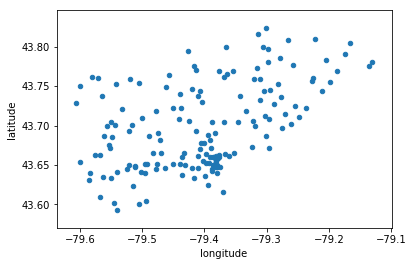

In [19]:
df.plot.scatter(x='longitude', y='latitude')
plt.show()

That looks alright. Finally, a small modification: Change column names for latitude and longitude to start with upper case L. For consistency.

I could have done this to begin with, but I was stupid then, and lazy now. 

In [20]:
df.rename(index=str, columns={"latitude":"Latitude", "longitude":"Longitude"}, inplace=True)

Now the DataFrame looks identical to the one from the exercise. But, I've dropped a bunch of neighborhoods along the way. And some of the people who grade my assignment may not appreciate that I'm using Geopy instead of the other methods suggested. 

So, I'll just download the CSV file provided by the instructors

### Using data uploaded by instructors

In [21]:
df1 = pd.read_csv('https://cocl.us/Geospatial_data')
df1.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [25]:
# I called my postcode column 'Postcode'. Gotta rename.
df1.rename(index=str, columns={"Postal Code":"Postcode"},inplace=True)

In [26]:
df = df0.merge(df1, how='inner', on='Postcode')
df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


And I'm done with getting geographical coordinates. 

All that remains is to get nearby venues, sort by priority, and cluster by most common venues. Easy-peasey (i.e., copy-paste from the earlier exercise).

## Exploring and clustering neighborhoods

### Explore nearby venues 

I'll do just the processing and ignore the intermediate steps with all the printing and diagnostics. 

In [27]:
with open('foursquare_cred.txt','r') as credFile:
    credentials = credFile.readlines()
    CLIENT_ID = credentials[0] # your Foursquare ID
    CLIENT_SECRET = credentials[1] # your Foursquare Secret
    VERSION = credentials[2] # Foursquare API version


In [28]:
LIMIT = 100 # No more than 100 results per query
radius = 500 # In a 500 metre radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

Parkwoods
Victoria Village
Harbourfront
Regent Park
Lawrence Heights
Lawrence Manor
Queen's Park
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design E

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Adelaide,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0
1,Agincourt,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,Agincourt North,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,Albion Gardens,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,Alderwood,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Bar,Steakhouse,Thai Restaurant,Café,Restaurant,American Restaurant,Burger Joint,Gym,Sushi Restaurant
1,Agincourt,Lounge,Clothing Store,Sandwich Place,Breakfast Spot,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
2,Agincourt North,Park,Playground,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
3,Albion Gardens,Grocery Store,Fried Chicken Joint,Pharmacy,Pizza Place,Sandwich Place,Discount Store,Liquor Store,Beer Store,Fast Food Restaurant,Japanese Restaurant
4,Alderwood,Pizza Place,Coffee Shop,Gym,Dance Studio,Skating Rink,Pharmacy,Sandwich Place,Pub,Pool,Dessert Shop


### Cluster neighborhoods

In [32]:
from sklearn.cluster import KMeans

In [33]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# Let's see how many neighborhoods belong to each cluster
toronto_merged.groupby('Cluster Labels').count()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0.0,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169
1.0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2.0,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
3.0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


The venue exploration bit isn't perfect. Some neighborhoods may not be associated with enough venues, and NaNs can creep in. Ignore these neighborhoods.

In [34]:
toronto_merged.dropna(axis=0, how='any',inplace=True)
toronto_merged.reset_index(inplace=True, drop=True)
print("Number of rows after dropping NaNs:", len(toronto_merged) )
print("Number of NaNs:", toronto_merged.isna().sum() )

Number of rows after dropping NaNs: 207
Number of NaNs: Postcode                  0
Borough                   0
Neighborhood              0
Latitude                  0
Longitude                 0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64


Now we've gone from 211 to 207 neighborhoods. 207's still a decent number though.

### Create and populate map

In [35]:
import folium
from matplotlib import cm, colors

In [36]:
# create map
map_clusters = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

In [37]:
toronto_merged.groupby('Cluster Labels').count()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0.0,169,169,169,169,169,169,169,169,169,169,169,169,169,169,169
1.0,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2.0,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21
3.0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
4.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


### Cluster 0

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Coffee Shop,Intersection,Hockey Arena,Portuguese Restaurant,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run
2,Harbourfront,Coffee Shop,Café,Bakery,Pub,Park,Breakfast Spot,Theater,Mexican Restaurant,Ice Cream Shop,Historic Site
3,Regent Park,Coffee Shop,Café,Bakery,Pub,Park,Breakfast Spot,Theater,Mexican Restaurant,Ice Cream Shop,Historic Site
4,Lawrence Heights,Clothing Store,Shoe Store,Furniture / Home Store,Event Space,Gift Shop,Miscellaneous Shop,Boutique,Vietnamese Restaurant,Coffee Shop,Accessories Store
5,Lawrence Manor,Clothing Store,Shoe Store,Furniture / Home Store,Event Space,Gift Shop,Miscellaneous Shop,Boutique,Vietnamese Restaurant,Coffee Shop,Accessories Store
6,Queen's Park,Coffee Shop,Diner,Gym,Burger Joint,Japanese Restaurant,Yoga Studio,Fast Food Restaurant,Creperie,Portuguese Restaurant,Café
9,Don Mills North,Gym / Fitness Center,Caribbean Restaurant,Café,Japanese Restaurant,Basketball Court,Baseball Field,Dim Sum Restaurant,Diner,Discount Store,Dog Run
10,Woodbine Gardens,Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Athletics & Sports,Gastropub,Intersection,Pharmacy,Café,Rock Climbing Spot,Bank
11,Parkview Hill,Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Athletics & Sports,Gastropub,Intersection,Pharmacy,Café,Rock Climbing Spot,Bank
12,Ryerson,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Middle Eastern Restaurant,Diner,Thai Restaurant,Bar,Restaurant,Ramen Restaurant


### Cluster 1

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
103,Emery,Furniture / Home Store,Baseball Field,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
104,Humberlea,Furniture / Home Store,Baseball Field,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
194,Humber Bay,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
195,King's Mill Park,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
196,Kingsway Park South East,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
197,Mimico NE,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
198,Old Mill South,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
199,The Queensway East,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
200,Royal York South East,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store
201,Sunnylea,Locksmith,Baseball Field,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Women's Store


### Cluster 2

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Park,Fast Food Restaurant,Food & Drink Shop,Bus Stop,Women's Store,Diner,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant
37,Caledonia-Fairbanks,Park,Women's Store,Fast Food Restaurant,Market,Pharmacy,Gift Shop,German Restaurant,Drugstore,Golf Course,Donut Shop
53,Scarborough Village,Playground,Women's Store,Dog Run,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
59,East Toronto,Park,Coffee Shop,Convenience Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
69,CFB Toronto,Park,Airport,Bus Stop,Electronics Store,Eastern European Restaurant,Empanada Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dance Studio
70,Downsview East,Park,Airport,Bus Stop,Electronics Store,Eastern European Restaurant,Empanada Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dance Studio
109,Lawrence Park,Park,Bus Line,Swim School,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Dance Studio
113,Weston,Park,Convenience Store,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
117,York Mills West,Bank,Park,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
134,Kingsview Village,Park,Pizza Place,Bus Line,Mobile Phone Shop,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Curling Ice


### Cluster 3

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Cloverdale,Bank,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Deli / Bodega
16,Islington,Bank,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Deli / Bodega
17,Martin Grove,Bank,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Deli / Bodega
18,Princess Gardens,Bank,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Deli / Bodega
19,West Deane Park,Bank,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Deli / Bodega


### Cluster 4

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(6, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Rouge,Fast Food Restaurant,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
8,Malvern,Fast Food Restaurant,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop


A fair number of neighborhoods have identical lists of venues attached to them. My guess is that these neighborhoods lie very close to each other. In fact, some may have coinciding locations. Let's see.

In [51]:
print("Number of rows in toronto_merged:", len(toronto_merged))
print("Number of unique locations (lat,long):", toronto_merged.groupby(['Latitude', 'Longitude']).ngroups )

Number of rows in toronto_merged: 207
Number of unique locations (lat,long): 100


Yup. 207 neighborhoods, but only a 100 unique locations. Not surprising. The CSV file supplied by the instructors had locations for each postcode, not neighborhood. There were only 103 postcodes, so 103 locations. I dropped a few locations during the venue exploration part, so I'm left with 100 locations. Fair enough. 